In [24]:
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV

import advanced_processor_chain_factory
from data import preprocess_data, vectorize_data, load_dataset
from w2v_adapter import Word2VecAdapter

def last_layer_activations(model, X):
    acs = [X] + (model.n_layers_ - 1) * [None]
    return model._forward_pass(acs)[model.n_layers_ - 2]

In [25]:
with open('best.pkl', 'rb') as f:
    mlp = pickle.load(f)

In [26]:
dataset = load_dataset()
DEBUG = False

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *preprocess_data(dataset, processor_chain=advanced_processor_chain_factory.create('lem'), debug=DEBUG))
vectorizer = Word2VecAdapter()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

# Show Clusters

In [28]:
tsne = PCA(n_components = 2)
X_tsne = tsne.fit_transform(X_train_vec[:1000])

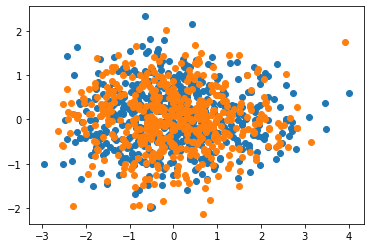

In [29]:
u_labels = np.unique(Y_train[:1000])
for i in u_labels:
    points = X_tsne[Y_train[:1000] == i]
    plt.scatter(points[:,0] , points[:,1] , label = i)
plt.show()

In [30]:
import copy

def evaluate_cluster(model_factory , possible_configs):
    columns = list(possible_configs[0].keys()) + ['train_adjusted_mutual_info_score',
                 'train_rand_score', 'test_adjusted_mutual_info_score',
                 'test_rand_score']
    kmeans_summary = pd.DataFrame()
    for config in possible_configs:
        model = model_factory(**config)
        Y_train_pred = model.fit_predict(X_train_vec, Y_train)
        Y_test_pred = model.predict(X_test_vec)
        train_ant_score = metrics.adjusted_mutual_info_score(Y_train, Y_train_pred)
        train_rand_score = metrics.adjusted_rand_score(Y_train, Y_train_pred)
        test_ant_score = metrics.adjusted_mutual_info_score(Y_test, Y_test_pred)
        test_rand_score = metrics.adjusted_rand_score(Y_test, Y_test_pred)
        ccon = copy.copy(config)
        config['train_adjusted_mutual_info_score'] = train_ant_score
        config['train_rand_score'] = train_rand_score
        config['test_adjusted_mutual_info_score'] = test_ant_score
        config['test_rand_score'] = test_rand_score
        kmeans_summary = kmeans_summary.append(config, ignore_index=True)
        print(f'Evaluation config {ccon} has been completed.')
    return kmeans_summary

In [31]:
evaluate_cluster(MiniBatchKMeans, [{'n_clusters':2}, {'n_clusters':10}, {'n_clusters':100}, {'n_clusters':4500}])

Evaluation config {'n_clusters': 2} has been completed.
Evaluation config {'n_clusters': 10} has been completed.
Evaluation config {'n_clusters': 100} has been completed.
Evaluation config {'n_clusters': 4500} has been completed.


,n_clusters,test_adjusted_mutual_info_score,test_rand_score,train_adjusted_mutual_info_score,train_rand_score
0,2.0,-0.000060,-0.000084,-0.000014,-0.000019
1,10.0,0.000113,0.000067,-0.000020,-0.000012
2,100.0,0.000327,0.000032,0.000059,0.000012
3,4500.0,-0.001273,-0.000012,0.000142,0.000003


In [32]:
evaluate_cluster(GaussianMixture, [{'n_components':2}, {'n_components':10}, {'n_components':100}, {'n_components':4500}])






Evaluation config {'n_components': 2} has been completed.
Evaluation config {'n_components': 10} has been completed.


KeyboardInterrupt: 